# Architecture
At a high-level, the steps of these systems are:

1- Convert question to SQL query: Model converts user input to a SQL query.
2- Execute SQL query: Execute the query.
3- Answer the question: Model responds to user input using the query results.

# Pipeline of the project
![Alt Text](sql_usecase.png)

In [1]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.utilities import SQLDatabase
from langchain_experimental.sql import SQLDatabaseChain
from langchain.prompts import SemanticSimilarityExampleSelector
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import Chroma
from langchain.prompts import FewShotPromptTemplate
from langchain.chains.sql_database.prompt import PROMPT_SUFFIX
from langchain.prompts.prompt import PromptTemplate
from decimal import Decimal
import sys
import os
from dotenv import load_dotenv
from sympy.physics.units import temperature

from few_shots import examples


In [2]:
# set env variables
load_dotenv('C:/Users/Assia/PycharmProjects/PythonProject/env')

True

### Connection with MySql Database

In [3]:
# db infos
db_user = "root"
db_password = os.getenv('DB_PASSWORD')
db_host = "localhost"
db_name = "atliq_tshirts"

In [4]:
# create the  SQL db object
db = SQLDatabase.from_uri(
        f"mysql+pymysql://{db_user}:{db_password}@{db_host}/{db_name}",
       sample_rows_in_table_info=3
     )

### Hugging Face Authentication & Embedding Model Initialization

In [5]:
from huggingface_hub import login

# login to hugging face using the api key
login(os.getenv('HUGGING_FACE_KEY'))

C:\Users\Assia\PycharmProjects\PythonProject\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
# create the embedding model
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

C:\Users\Assia\AppData\Local\Temp\ipykernel_6372\102896465.py:1: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")


### Mistral AI Authentification & Model Initialization

In [7]:
!pip install -qU "langchain[mistralai]"

In [8]:
import getpass
import os

# enter the api key of mistral AI
if not os.environ.get("MISTRAL_API_KEY"):
  os.environ["MISTRAL_API_KEY"] = getpass.getpass("Enter API key for Mistral AI: ")

In [28]:
from langchain.chat_models import init_chat_model

# initialize the llm
llm = init_chat_model(
    "mistral-large-latest",
    model_provider="mistralai",
)

In [10]:
from few_shots import examples

# prepare the few-shot examples for vectorization
to_vectorize = [" ".join(example.values()) for example in examples]

### Data Preparation & Vectorization

In [11]:
to_vectorize

['List all t-shirts. SELECT * FROM t_shirts;',
 "Show all black t-shirts. SELECT * FROM t_shirts WHERE color = 'Black';",
 "List all Adidas t-shirts in size L. SELECT * FROM t_shirts WHERE brand = 'Adidas' AND size = 'L';",
 'Provide a list of t-shirt IDs that have a price greater than $40 SELECT t_shirt_id FROM t_shirts WHERE price > 40;',
 'Find all t-shirts that are out of stock. SELECT * FROM t_shirts WHERE stock_quantity = 0;',
 'List all t-shirts that have a discount. SELECT t.*\nFROM t_shirts t\nJOIN discounts d ON t.t_shirt_id = d.t_shirt_id;',
 'Show t-shirts with more than 50 items in stock. SELECT * FROM t_shirts WHERE stock_quantity > 50;',
 'Find the discount percentage for each t-shirt. SELECT t_shirt_id, pct_discount FROM discounts;',
 'Show t-shirts with their discount percentage. SELECT t.t_shirt_id, t.brand, t.color, t.size, t.price, d.pct_discount\nFROM t_shirts t\nLEFT JOIN discounts d ON t.t_shirt_id = d.t_shirt_id;',
 'Which t-shirts have a discount greater than 1

In [12]:
# create the vector store object
vectorstore = Chroma.from_texts(
    texts=to_vectorize,
    embedding=embeddings,
    metadatas=examples,
    persist_directory=None
)

In [13]:
# the exmaple selector for dynamic selection of few-shots
example_selector = SemanticSimilarityExampleSelector(
        vectorstore=vectorstore,
        k=5,
        input_keys=["input"],
    )

### Prompt preparation

In [32]:
# params for the prompt
example_prompt = PromptTemplate.from_template("User input: {input}\nSQL query: {query}")

In [33]:
prefix = """You are a MySQL expert. Given an input question, create a syntactically correct MySQL query to run to help find the answer. Unless the user specifies in the question a specific number of examples to obtain, query for at most {top_k} results using the LIMIT clause as per MySQL. You can order the results by a relevant column to return the most interesting examples in the database.

Never query for all the columns from a specific table, only ask for a the few relevant columns given the question.

Pay attention to use only the column names that you can see in the schema description. Be careful to not query for columns that do not exist. Also, pay attention to which column is in which table.

Only use the following tables:
{table_info}

Below are a number of examples of questions and their corresponding SQL queries."""

### LangGraph State
A state is like a notebook that our system uses to keep track of what happens during the task, it stores the data that will be used by each step, either for reading or updating the data.

You store all of this in something like a Python TypedDict or a Pydantic model. It’s like a shared folder that all steps in the chain can read from and write to.

For this application, we can just keep track of the input question, generated query, query result, and generated answer:

In [34]:
from typing_extensions import TypedDict

# state of the data
class State(TypedDict):
    question: str
    query: str
    result: str
    answer: str

### Chain
At the end of this project, we will use LangGraph, wich is a tool used for building language model workflows, and we need to define our "Chain" which is a sequence of conected nodes or steps, that define the workflow of our system.
These steps are defined as follows :


#### The First Step

In [38]:
from typing_extensions import Annotated


class QueryOutput(TypedDict):
    """generated SQL query."""

    query: Annotated[str, ..., "Syntactically valid SQL query."]


def write_query(state: State):
    """generate SQL query to fetch information."""
    prompt = FewShotPromptTemplate(
    example_selector=example_selector,
    example_prompt=example_prompt,
    prefix=prefix,
    suffix="User input: {input}\nSQL query: ",
    input_variables=["input", "table_info", "top_k"],
).format(input=state['question'], table_info=db.table_info, top_k = 3)

    structured_llm = llm.with_structured_output(QueryOutput)
    result = structured_llm.invoke(prompt)
    return {
        "question": state["question"],
        "query": result["query"]
    }

Some tests

In [40]:
write_query({"question": "list all t-shirts"})

{'question': 'list all t-shirts',
 'query': 'SELECT brand, color, size, price FROM t_shirts LIMIT 3;'}

In [41]:
write_query({"question": "How many Adidas T shirts I have left in my store?"})

{'question': 'How many Adidas T shirts I have left in my store?',
 'query': "SELECT COUNT(*) FROM t_shirts WHERE brand = 'Adidas' AND stock_quantity > 0;"}

In [42]:
write_query({"question": "How many T shirts of size M I have left in my store?"})

{'question': 'How many T shirts of size M I have left in my store?',
 'query': "SELECT COUNT(*) FROM t_shirts WHERE size = 'M' AND stock_quantity > 0;"}

#### The Second Step

In [43]:
from langchain_community.tools.sql_database.tool import QuerySQLDatabaseTool


def execute_query(state: State):
    """Execute SQL query."""
    execute_query_tool = QuerySQLDatabaseTool(db=db)
    return {
        "question": state["question"],
        "query": state["query"],
        "result": execute_query_tool.invoke(state["query"])
    }

test

In [44]:
execute_query({'question': 'How many Adidas T shirts I have left in my store?',
 'query': "SELECT COUNT(*) FROM t_shirts WHERE brand = 'Adidas' AND stock_quantity > 0;"})

{'question': 'How many Adidas T shirts I have left in my store?',
 'query': "SELECT COUNT(*) FROM t_shirts WHERE brand = 'Adidas' AND stock_quantity > 0;",
 'result': '[(15,)]'}

#### The Fourth Step

In [45]:
def generate_answer(state: State):
    if state["result"] == '' :
        return {
        "question": state["question"],
        "query": state["query"],
        "result": state["result"],
        "answer": 'No result found!'
    }
    """Answer question using retrieved information as context."""
    prompt = (
        "Given the following user question, corresponding SQL query, "
        "and SQL result, answer the user question.\n\n"
        f'Question: {state["question"]}\n'
        f'SQL Query: {state["query"]}\n'
        f'SQL Result: {state["result"]}'
    )
    response = llm.invoke(prompt)
    return {
        "question": state["question"],
        "query": state["query"],
        "result": state["result"],
        "answer": response.content
    }

test

In [46]:
input_llm ={'question': 'How many Adidas T shirts I have left in my store?',
 'query': "SELECT COUNT(*) FROM t_shirts WHERE brand = 'Adidas' AND stock_quantity > 0;",
 'result': '[(15,)]'}

In [47]:
generate_answer(input_llm)

{'question': 'How many Adidas T shirts I have left in my store?',
 'query': "SELECT COUNT(*) FROM t_shirts WHERE brand = 'Adidas' AND stock_quantity > 0;",
 'result': '[(15,)]',
 'answer': 'Based on the SQL result, you have 15 Adidas T-shirts left in your store.'}

###

### Orchestrating with LangGraph

Finally, we compile our application into a single graph object. In this case, we are just connecting the three steps into a single sequence.



In [48]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence(
    [write_query, execute_query, generate_answer]
)
graph_builder.add_edge(START, "write_query")
graph = graph_builder.compile()

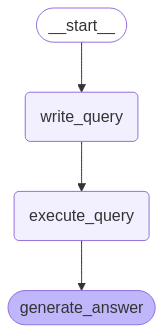

In [49]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

### Testing the application, with each step of the chain

In [51]:
for step in graph.stream(
    {"question": "How many T-shirts of size M do we have in stock?"}, stream_mode="updates"
):
    print(step)

{'write_query': {'question': 'How many T-shirts of size M do we have in stock?', 'query': "SELECT SUM(stock_quantity) FROM t_shirts WHERE size = 'M';"}}
{'execute_query': {'question': 'How many T-shirts of size M do we have in stock?', 'query': "SELECT SUM(stock_quantity) FROM t_shirts WHERE size = 'M';", 'result': "[(Decimal('898'),)]"}}
{'generate_answer': {'question': 'How many T-shirts of size M do we have in stock?', 'query': "SELECT SUM(stock_quantity) FROM t_shirts WHERE size = 'M';", 'result': "[(Decimal('898'),)]", 'answer': 'You have 898 T-shirts of size M in stock.'}}


##### Final mini test

In [52]:
write_query({"question": "What is the total price of Adidas t-shirts after applying discounts?"})

{'question': 'What is the total price of Adidas t-shirts after applying discounts?',
 'query': "SELECT SUM(t.price * t.stock_quantity * (1 - d.pct_discount / 100)) AS total_discounted_price FROM t_shirts t JOIN discounts d ON t.t_shirt_id = d.t_shirt_id WHERE t.brand = 'Adidas';"}